# Final Project | Simpsons DCGAN
### Emily Lupini


**This program needs a GPU to run efficiently. If you do not have a GPU I recommend running it on [Google's Cloud Console](console.cloud.google.com). If neither resource is available to you expect multiple hours for over 1,000 epochs, and an end result unachievable within a day. Current epoch/batch_size below took about 3 hours with a GPU.**

The following Simpsons Deep Convolutional Generative Adversarial Network (DCGAN) is inteded to generate images of Homer Simpson based off of preexisting Homer images. With this project I hope to demonstrate how Machine Learning, and specifically Generative Adversarial Networks (GAN), can create effective imposters that we may not expect.

A GAN is a machine learning algorithm that uses multiple models to create new data based off of given data. The first model is called the generator, or counterfeiter, which takes noise and attempts to provide realistic enough data to fool the second model. The second model is called the discriminator, or the police, which evaluates the generated data along with the given data. This model provides feedback for the generator to continue evolving from its previous epoch. Some discriminators can give detailed feedback; however, the GAN implemented in my project can only tell the generator whether or not it thinks a specific image is valid or fake.

A DCGAN is a version of a GAN that uses convolutional layers in the discriminator and generator. I chose to use a DCGAN over other versions because convolutional neural networks have shown effectivenes with image recognition. According to Radford, Metz, and Chintala, authors of [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf), DCGAN's should use only relu or leakyReLU activation layers for all but the final layer. The final layer for the generator should be tanh, and the final layer for the discriminator should be sigmoid.

---

# Imports
---

Libraries used:
* ` __future__`
    * ensures compatability with other versions of python
* `cv2`
    * file reading
* `numpy`
    * random integer selection
    * data generation
    * array formatting
* `pathlib` 
    * file reading
* `matplotlib.pylot`
    * image plotting
* `keras`
    * Sequential Neural Net

In [1]:
from __future__ import print_function, division

import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


# `class DCGAN()`

Ideas and Examples from Chapter 6 in [_Keras Deep Learning Cookbook_](https://www.packtpub.com/big-data-and-business-intelligence/keras-deep-learning-cookbook) by Rajdeep Dua and Manpreet Sigh Ghotra.

* __Bolded methods are exclusively mine.__
* *Italacized methods are adapted from the Keras Deep Learning Cookbook.*
* ***Bolded and italicized are a combination of my work and the examples found in the _Keras Deep Learning Cookbook_.***
    * Bolded statements within these methods are my additions, all other statements are adapted from the book

---

* ***`__init__(self)`***
    * Parameters:
        * self
    * Returns:
        * none
    * Process:
        * __Process the data__
        * Define data shape
        * Build and compile the discriminator
        * Build the generator
        * Define input length for generator
        * Enforce that the discriminator does not train
        * Validate generated images
        * Create a combined model that compares generator with discriminator
        
* **`process_data(self)`**
    * Parameters:
        * self
    * Returns:
        * pkm
            * list of pokemon images
    * Process:
        * Read in images
        * Enforce white backgrounds

* **`plot_simpsons(self)`**
    * Parameters:
        * self
    * Returns: 
        * none
    * Process:
        * Create 5X5 grid
        * Set grid size
        * Fill with first 25 images
        
* ***`build_generator(self)`***
    * Parameters:
        * self
    * Returns:
        * Model(noise, img)
            * Model and data to be classified by the discriminator
    * Process:
        * **5 Layers: layer sizes chosen by me**
            * Dense layer: 256 * 12 * 12    
                * Activation - `relu`
            * Convolutional 2D: 24, 24, 256 
                * Activation - `relu`
            * Convolutional 2D: 48, 48, 128  
                * Activation - `relu`
            * Convolutional 2D: 96, 96, 64 
                * Activation - `relu`
            * Convolutional 2D: 192, 192, 3 
                * Activation - `tanh`
* ***`build_discriminator(self)`***
    * Parameters:
        * self
    * Returns:
        * Model(img, validity)
    * Process:
        * **6 Layers: layer sizes chosen by me**
            * Convolutional 2D:  96, 96, 32  
                * Activation - `LeakyReLU`
            * Convolutional 2D:  48, 48, 64  
                * Activation - `LeakyReLU`
            * Convolutional 2d: 25, 25, 128
                * Activation - `LeakyReLU`
            * Convolutional 2D:  13, 13, 128 
                * Activation - `LeakyReLU`
            * Convolutional 2D:  7, 7, 256   
                * Activation - `LeakyReLU`
            * Dense Layer: 1                 
                * Activation - `sigmoid`

* ***`train(self, epochs, batch_size=25, save_interval=50)`***
    * Parameters:
        * self
        * epochs
        * batch_size
            * How many images to generate/will be trained on
        * save_interval
            * At which epoch images will be saved/plotted
    * Returns: 
        * None
    * Process:
        * Create labels
        * At each epoch:
            * Select random images
            * Train the discriminator
            * Train the generator in combined model
            * Every 500 epochs:
                * **Save loss and accuracy data** 
            * On save interval epoch:
                * **Output/save images**
        * **Plot loss and accuracy**
        
* **`plot_stats(self, g, d, title, ylabel)`**
    * Parameters:
        * self
        * g
            * Generator data
        * d
            * Discriminator data
        * title
        * ylabel
    * Returns:
        * None
    * Process:
        * Plot generator data
        * Plot discriminator data
        * Add legend
        * Add xlabel, ylabel, and title
        * Show plot


* **`plot_images(self, epoch, gen_imgs)`**
    * Parameters:
        * self
        * epoch
            * Current epoch for title of save file
        * gen_imgs
            * Generated images to be plotted
    * Returns:
        * None
    * Process:
        * Create grid
        * Set grid size
        * Fill with gen_imgs

In [4]:
class DCGAN():
    
    def __init__(self):
        
        self.simpsons = self.process_data()
        self.plot_simpsons()
        self.simpsons = (np.asarray(self.simpsons) / 127.5) - 1
        
        self.img_rows = 192
        self.img_cols = 192
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        optimizer = Adam(0.0002, 0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer=optimizer,
                                  metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(100,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
            
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', 
                              optimizer=optimizer,
                              metrics=['accuracy'])
        
    def process_data(self):
        simpsons = []

        img_path = 'simpsons-faces/homer'

        for simpson in Path(img_path).glob('*.png'):
            image = cv.imread(str(simpson), cv.IMREAD_UNCHANGED)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (192, 192))
            simpsons.append(image)
            
        return simpsons
    
    def plot_simpsons(self):
        rows = 4
        cols = 4
        axes = []
        fig = plt.figure()
        fig.set_size_inches(20, 15)
        for i in range(rows*cols):
            axes.append(fig.add_subplot(rows, cols, i+1))
            plt.imshow(self.simpsons[i])
            plt.axis('off')
        plt.show()
        
    def build_generator(self):
        model = Sequential()
        
        model.add(Dense(256 * 12 * 12, activation='relu',
                 input_dim=self.latent_dim))
        model.add(Reshape((12, 12, 256)))
        model.add(UpSampling2D())
        
        model.add(Conv2D(256, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(64, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(self.channels, 
                         kernel_size=5, 
                         padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2,
                        input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(ZeroPadding2D(padding=((0,1), (0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, 
                         padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)
        
    def train(self, epochs, batch_size=25, save_interval=50):
        
        d_loss_stats = []
        g_loss_stats = []
        d_acc_stats = []
        g_acc_stats = []
        
        valid = np.zeros((batch_size, 1))
        fake = np.ones((batch_size, 1))
        
        for epoch in range(epochs):
            
            idx = np.random.randint(0, self.simpsons.shape[0],
                                   batch_size)
            imgs = self.simpsons[idx]
            
            noise = np.random.normal(0, 1, (batch_size,
                                           self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs,
                                                           valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs,
                                                           fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            g_loss = self.combined.train_on_batch(noise, valid)
            
            if epoch % 500 == 0:
                g_loss_stats.append(g_loss[0])
                g_acc_stats.append(g_loss[1])
                d_loss_stats.append(d_loss[0])
                d_acc_stats.append(d_loss[1])
                
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
                        % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
                self.plot_images(epoch, gen_imgs)
        
        self.plot_stats(g_loss_stats, d_loss_stats, 'Loss Chart', 'Loss')
        self.plot_stats(g_acc_stats, d_acc_stats, 'Accuracy Chart', 'Accuracy')
        
    def plot_stats(self, g, d, title, ylabel):
        x = list(range(0, len(g)))
        x = [t * 500 for t in x]
            
        plt.figure(figsize=(20,15))
        plt.plot(x, g, color='green', label='Generator')
        plt.plot(x, d, color='purple', label='Discriminator')
        plt.legend(loc='upper left')
        plt.title(title)
        plt.ylabel(ylabel, fontsize=20)
        plt.xlabel('Epoch', fontsize=20)
        plt.show()
                
    def plot_images(self, epoch, gen_imgs):
            rows = 5
            cols = 4
            axes = []
            fig = plt.figure()
            fig.set_size_inches(20, 15)
            for i in range(rows*cols):
                axes.append(fig.add_subplot(rows, cols, i+1))
                plt.imshow(gen_imgs[i] * 0.5 + 0.5)
                plt.axis('off')
            
            # Uncomment below for Jupyter Notebook use
            plt.show()
            
            # Creates file of images
            # Uncomment below for .py use
            # plt.savefig('homer_gen/lupini_%i_epoch.png' % (epoch))


# The Data
---

In order to get the best results I decided to use only photos where a majority of Homer's face was in frame and he was looking to the left. I also eliminated all photos that had other characters in them. This brought my dataset from 10,000 Simpsons images to approximately 2,000 Homer images, to about 600 usable images. I decided to duplicate my photos as well; however, I feel this step was unnecessary.

Below is a snapshot of the first 25 images in my dataset.

Dataset is from [kaggle.com](https://www.kaggle.com/kostastokis/simpsons-faces), but I modified it with the above requirements. 

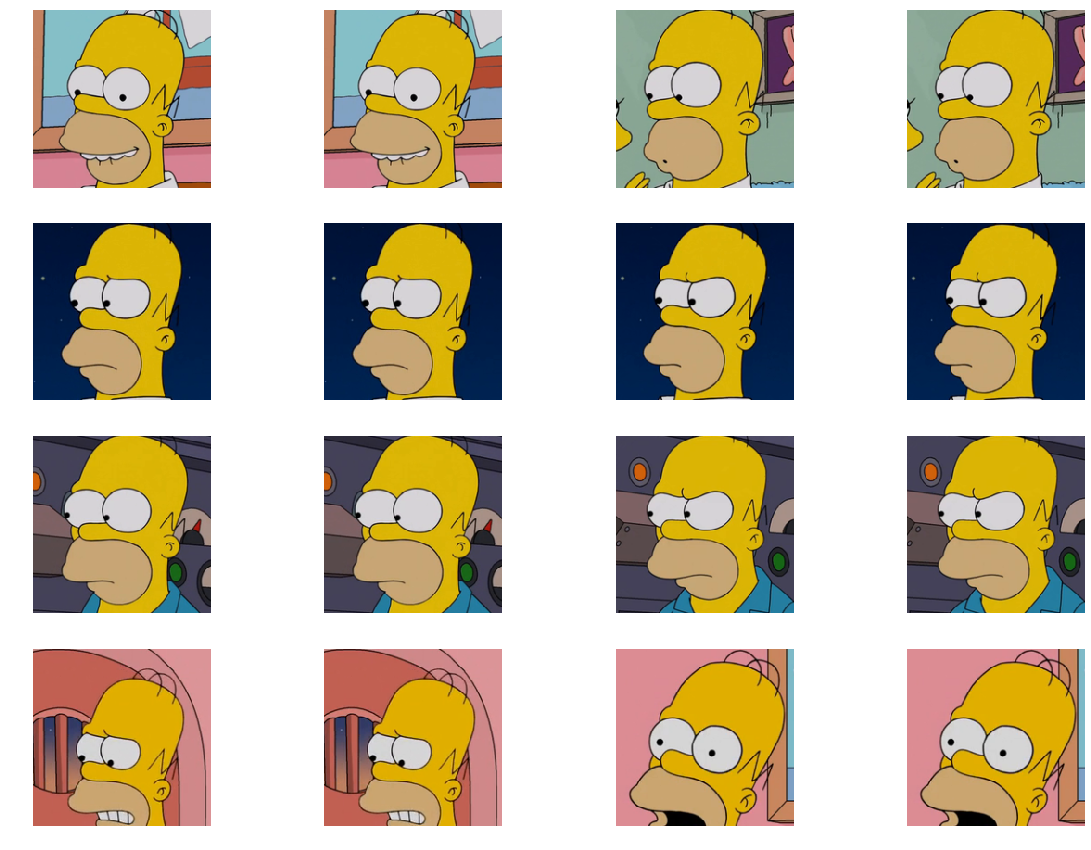

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 49, 49, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 49, 49, 64)        0         
__________

In [5]:
dcgan = DCGAN()

# The Generated Data
---
When running this outside of Jupyter Notebook I highly recommend a smaller save interval in order to visualize a more gradual fitting process. 30,000 epochs will likely overfit, but I found the overfitted images interesting so I kept them here. 

C:\Users\Peter\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.065245, acc.: 50.00%] [G loss: 0.749498]


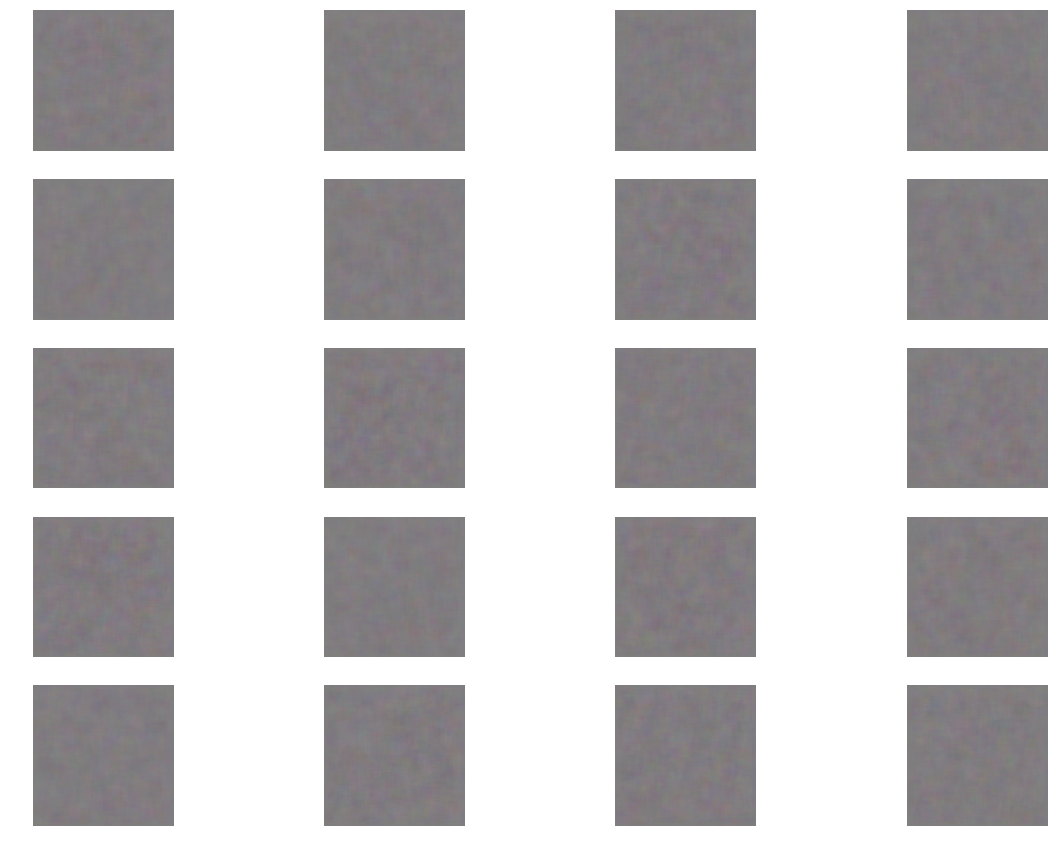

5000 [D loss: 0.017185, acc.: 100.00%] [G loss: 4.945184]


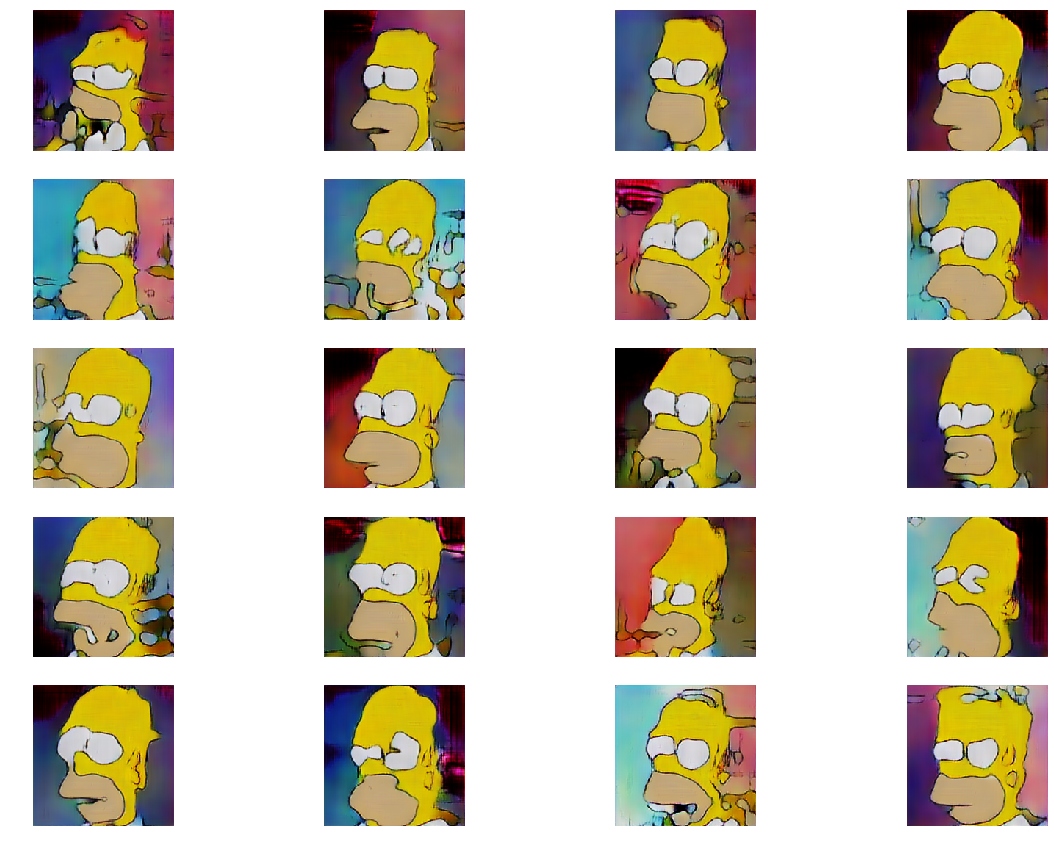

10000 [D loss: 0.013458, acc.: 100.00%] [G loss: 7.668565]


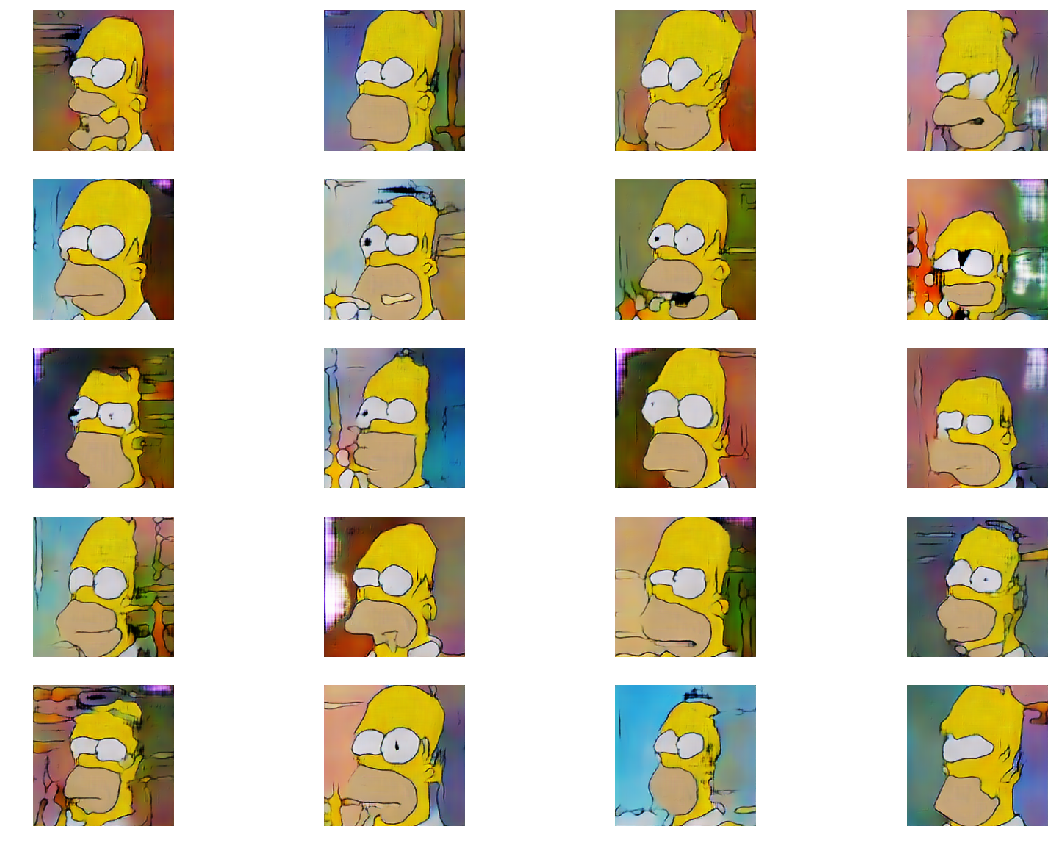

15000 [D loss: 0.024016, acc.: 100.00%] [G loss: 7.577839]


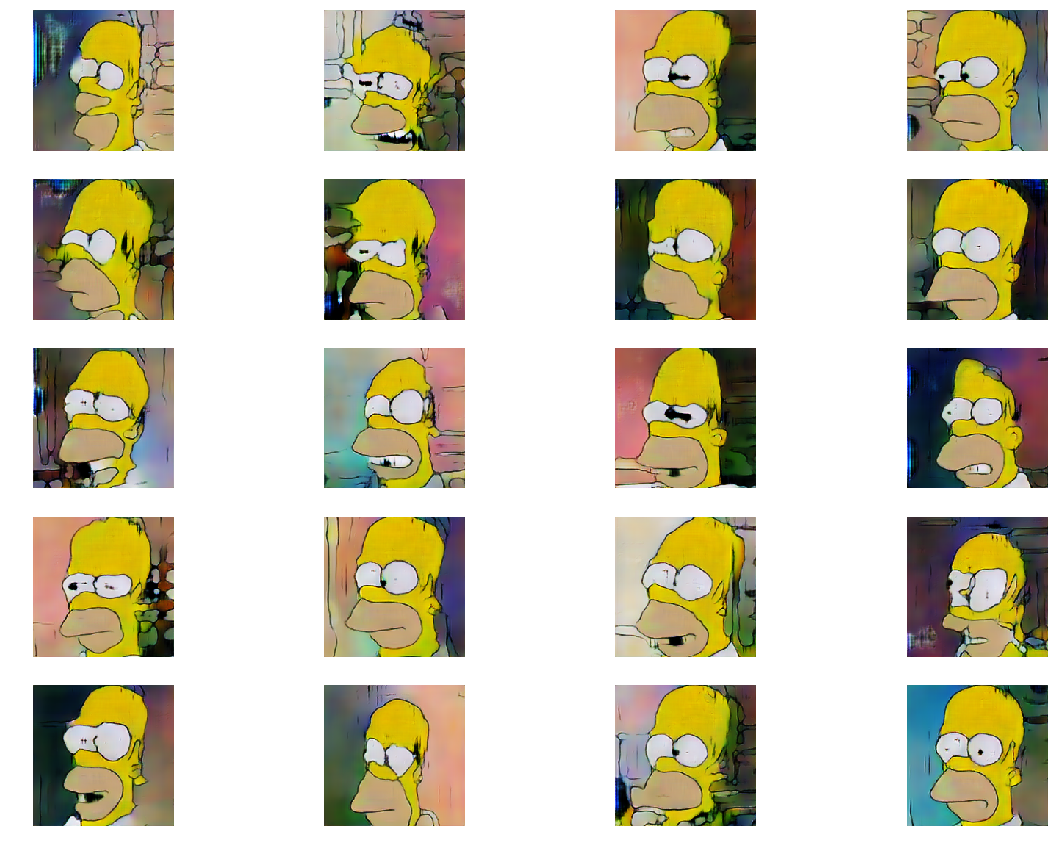

20000 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.942385]


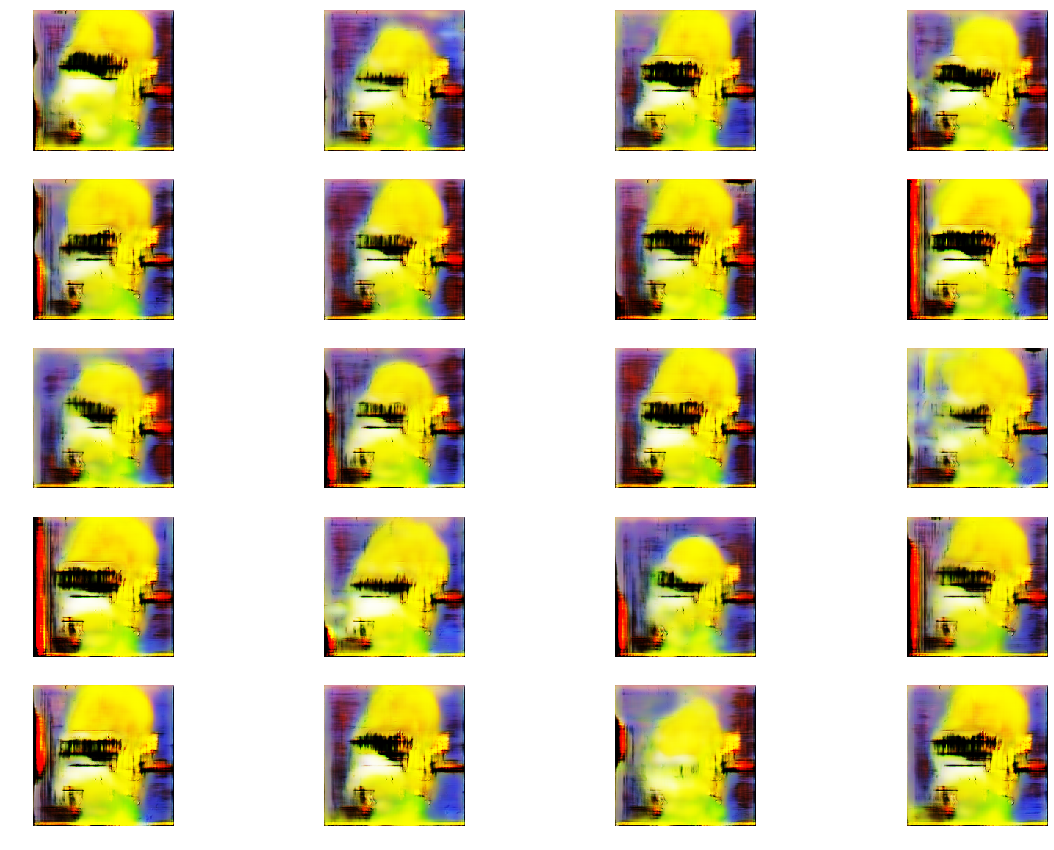

25000 [D loss: 7.971192, acc.: 50.00%] [G loss: 15.942385]


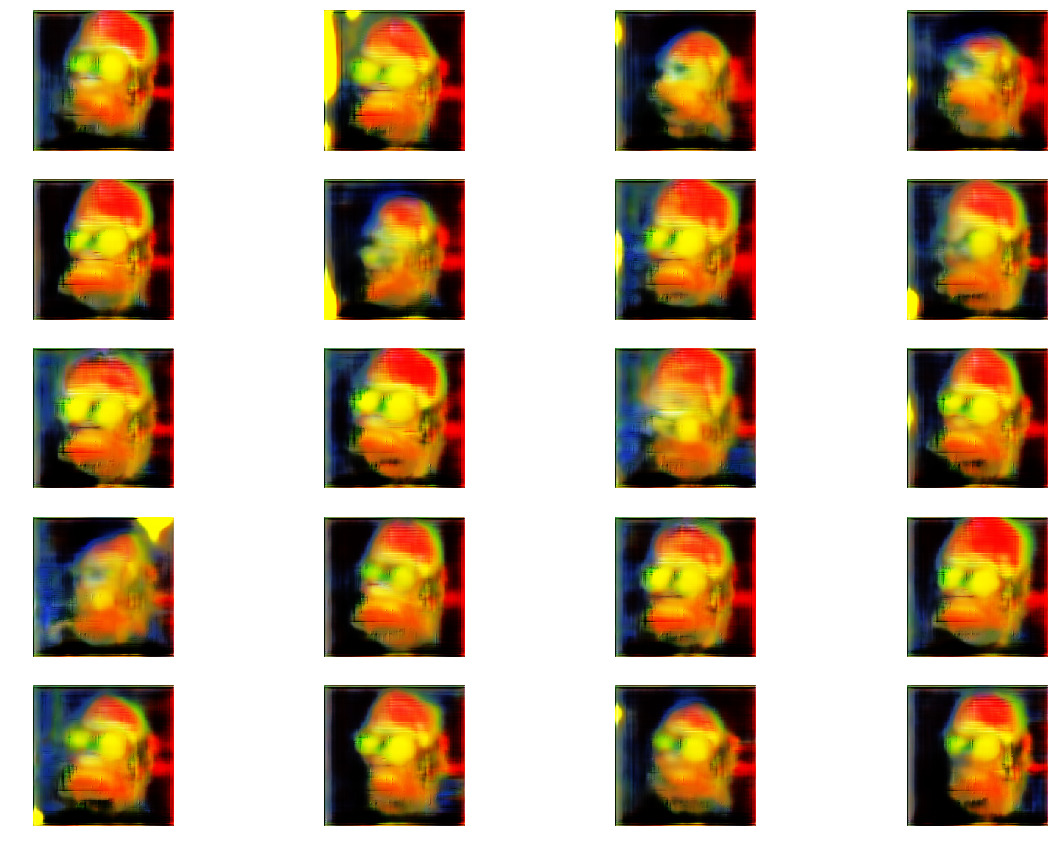

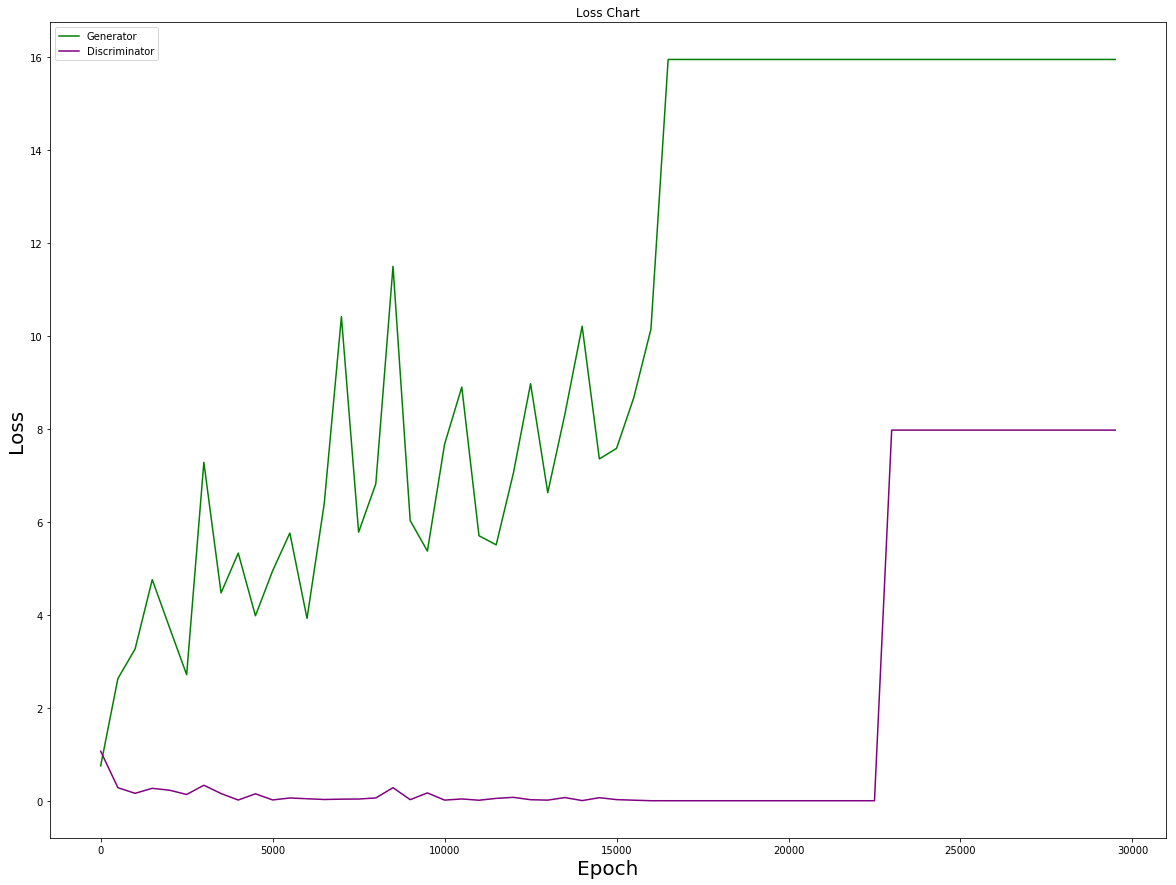

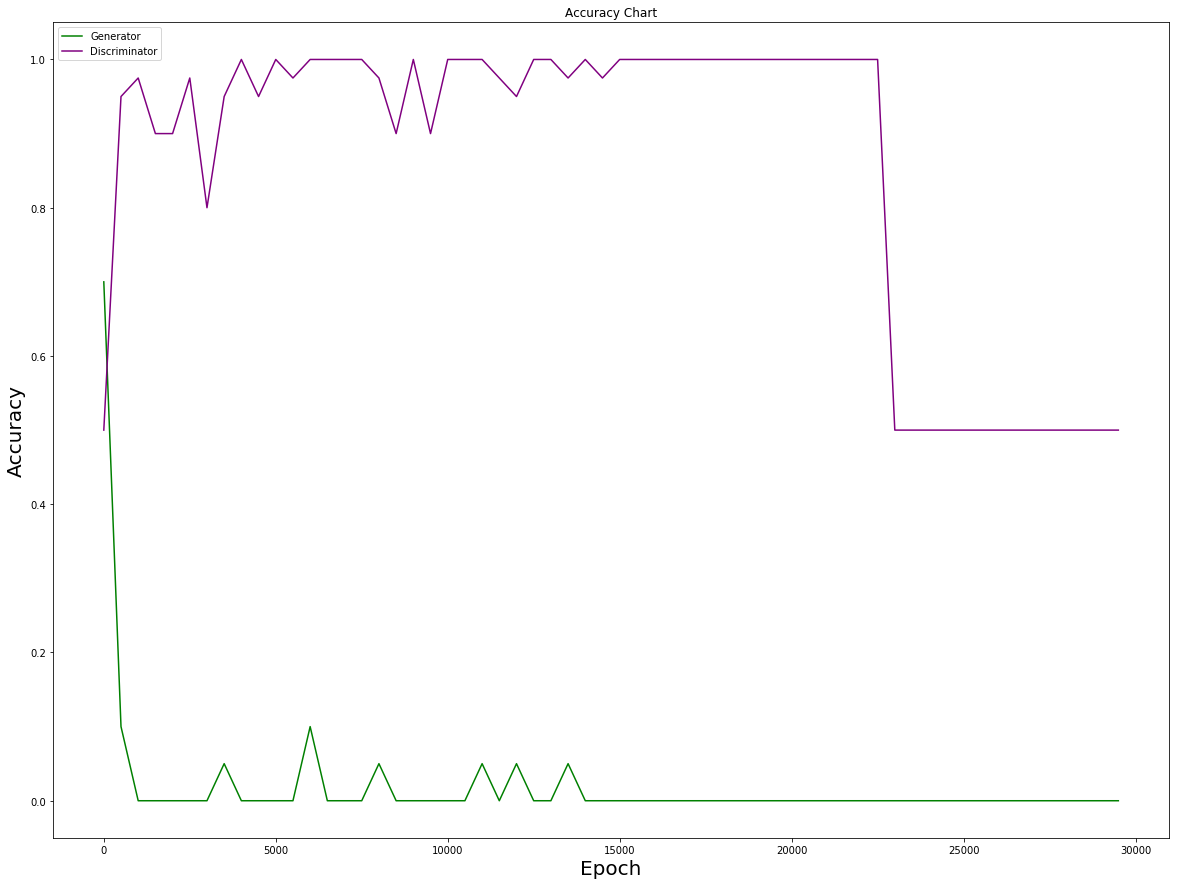

In [6]:
dcgan.train(epochs=30000, batch_size=20, save_interval=5000)

# Reflection
---

For the discriminator I found adding an additional convolutional layer helped speed up the process for better image generation. Additionally, starting with a larger layer for the generator aided the efficiency. Using BatchNormalization and Dropouts ensured diverse data usage on my dataset, and, therefore, less chance of overfitting. 

Ideally having an even more consistent image set would have probably benifitted my results. If the subject (not the image) was always the same size I believe my model could have performed better. 

#### Loss/Accurcay Evaluation

Unfortunately, due to the need for tens of thousands of epochs for this DCGAN, plotting loss and accuracy at every epoch was unreadable. Instead, I opted to save this data only at ever 500 epochs.

Interpreting loss and accuracy with a GAN is similarly un-intuitive. In theory, we should see an inverse relationship: as the generator gets better at generating images, the discriminator should be less capable of distinguishing between valid and fake images. 

As we can see in the loss plot above, the best fit occurs between 15,000 and 20,000 epochs, which isn't as straight forward to interpret in the accuracy chart.